## Vanilla KNN Model 

Built with reference to http://cs231n.github.io/assignments2017/assignment1/ 

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

### Import Function

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Data Processing

In [3]:
PATH = 'data/cifar10'

In [6]:
X_train, y_train, X_test, y_test = load_CIFAR10(f'{PATH}')

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [8]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape)

(49000, 32, 32, 3) (49000,) (1000, 32, 32, 3) (1000,) (500, 32, 32, 3) (500,) (1000, 32, 32, 3) (1000,)


In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_val.shape, X_test.shape)

(49000, 3072) (1000, 3072) (1000, 3072)


### Nearest Neighbour

In [10]:
import numpy as np

class NearestNeighbour(object):
    def __init__(self):
        pass
    
    def train(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X, k=1, num_loops=0):
        num_test = X.shape[0]
        
        Ypred = np.zeros(num_test)
        
        for i in range(num_test):
            # L1 Distance
            distances = np.sum(np.abs(self.X - X[i,:]), axis = 1)
            # L2 Distance
#             distances = np.sqrt(np.sum(np.square(self.X - X[i,:]), axis=1 ))
            min_index = np.argmin(distances)
            Ypred[i] = self.y[min_index]
            
        return Ypred     

In [11]:
classifier = NearestNeighbour()
classifier.train(X_train, y_train)
y_predict = classifier.predict(X_test)
print('accuracy: %f' % ( np.mean(y_predict == y_test) ))

accuracy: 0.290000


### K Nearest Neighbour

In [40]:
np.square(X_test).sum(axis=1, keepdims=True).shape

(500, 1)

In [41]:
np.square(X_train).sum(axis=1).shape

(5000,)

In [100]:
X_test.dot(X_train.T).shape

(500, 5000)

In [46]:
dist = np.square(X_test).sum(axis=1, keepdims=True) + np.square(X_train).sum(axis=1) + 2 * X_test.dot(X_train.T)

In [47]:
dist.shape

(500, 5000)

In [99]:
closest_y = y_train[np.argsort(dist[0])[:5]]; closest_y

array([4, 4, 0, 4, 6])

In [68]:
np.bincount(closest_y)

array([1, 0, 0, 0, 3, 0, 1])

In [67]:
np.argmax(np.bincount(closest_y))

4

In [38]:
class KNearestNeighbour(object):
    
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X, k=1):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # L2 distance
        # p^2 + q^2 - 2pq
        dists = np.square(X).sum(axis=1, keepdims=True) + np.square(self.X_train).sum(axis=1) - 2 * X.dot(self.X_train.T)
        
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])[:k]]
            y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred

In [40]:
classifier = KNearestNeighbour()
classifier.train(X_train, y_train)
y_predict = classifier.predict(X_test, k=5)

print('accuracy: %f' % ( np.mean(y_predict == y_test) ))

accuracy: 0.278000


### Cross Validation

In [81]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    for n in range(num_folds):
        X_train_set = np.concatenate([j for i, j in enumerate(X_train_folds) if i != n])
        y_train_set = np.concatenate([j for i, j in enumerate(y_train_folds) if i != n])
        classifier = KNearestNeighbour()
        classifier.train(X_train_set, y_train_set)
        y_cross_val_predict = classifier.predict(X_train_folds[n], k)
        accuracy = np.mean(y_cross_val_predict == y_train_folds[n])
        k_to_accuracies.setdefault(k, []).append(accuracy)

In [82]:
k_to_accuracies

{1: [0.263, 0.257, 0.264, 0.278, 0.266],
 3: [0.239, 0.249, 0.24, 0.266, 0.254],
 5: [0.248, 0.266, 0.28, 0.292, 0.28],
 8: [0.262, 0.282, 0.273, 0.29, 0.273],
 10: [0.265, 0.296, 0.276, 0.284, 0.28],
 12: [0.26, 0.295, 0.279, 0.283, 0.28],
 15: [0.252, 0.289, 0.278, 0.282, 0.274],
 20: [0.27, 0.279, 0.279, 0.282, 0.285],
 50: [0.271, 0.288, 0.278, 0.269, 0.266],
 100: [0.256, 0.27, 0.263, 0.256, 0.263]}

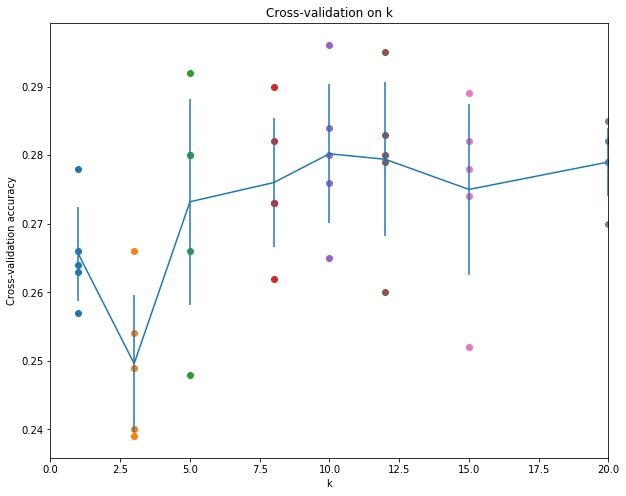

In [83]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.xlim(0,20)
plt.show()

In [84]:
classifier = KNearestNeighbour()
classifier.train(X_train, y_train)
y_predict = classifier.predict(X_test, k=10)

print('accuracy: %f' % ( np.mean(y_predict == y_test) ))

accuracy: 0.282000
